In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv(r'C:\Users\ASUS\Desktop\Climate1\sorted_aqi_hourly_dataset.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

df_daily = df.groupby(['City', 'date'])[['PM2.5', 'PM10']].mean().reset_index()
df_daily['Index Value'] = df_daily['PM2.5']  # Approximate AQI

df_daily['date'] = pd.to_datetime(df_daily['date'])

def train_hybrid_model(city, future_date):
    df_city = df_daily[df_daily['City'] == city].copy()
    if df_city.empty:
        return f"City '{city}' not found in the dataset."

    df_city.set_index('date', inplace=True)
    df_city = df_city.asfreq('D')
    df_city['Index Value'] = df_city['Index Value'].fillna(df_city['Index Value'].rolling(7, min_periods=1).mean())

    # Train Holt-Winters Model
    model_hw = ExponentialSmoothing(
        df_city['Index Value'], 
        trend='mul', 
        seasonal='mul', 
        seasonal_periods=365
    ).fit()

    df_city['HW_Predicted'] = model_hw.fittedvalues
    df_city['Error'] = df_city['Index Value'] - df_city['HW_Predicted']

    # Feature Engineering for XGBoost
    df_city['day'] = df_city.index.day
    df_city['month'] = df_city.index.month
    df_city['year'] = df_city.index.year
    df_city['dayofweek'] = df_city.index.dayofweek

    features = ['day', 'month', 'year', 'dayofweek']
    X = df_city[features]
    y = df_city['Error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    model_xgb.fit(X_train, y_train)
    
    # Evaluate XGBoost model
    y_pred_test = model_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    
    # Predict future AQI
    future_date = pd.to_datetime(future_date)
    days_ahead = (future_date - df_city.index[-1]).days
    if days_ahead < 1:
        return "Future date must be beyond the last recorded date."
    
    hw_forecast = model_hw.forecast(steps=days_ahead).iloc[-1]
    
    future_features = pd.DataFrame({
        "day": [future_date.day],
        "month": [future_date.month],
        "year": [future_date.year],
        "dayofweek": [future_date.dayofweek]
    })
    
    xgb_correction = model_xgb.predict(future_features)[0]
    final_prediction = hw_forecast + xgb_correction
    final_prediction = max(final_prediction, 0)

    past_errors = np.abs(df_city['HW_Predicted'] - df_city['Index Value'])
    mape = np.mean((past_errors / df_city['Index Value'].replace(0, np.nan)).dropna())
    confidence_prob = max(0, 1 - mape) * 100

    return {
        "City": city,
        "Future Date": future_date.strftime("%Y-%m-%d"),
        "Predicted AQI": round(final_prediction, 2),
        "Prediction Confidence": round(confidence_prob, 2),
        "MSE": round(mse, 2)
    }

# Example usage
if __name__ == "__main__":
    city_name = input("Enter city name: ")
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_hybrid_model(city_name, future_date)
    print("\nHybrid AQI Prediction Result:")
    print(result)


d:\Anacondaa\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



Hybrid AQI Prediction Result:
{'City': 'Delhi', 'Future Date': '2025-02-25', 'Predicted AQI': 4934486.53, 'Prediction Confidence': 62.16, 'MSE': 54437.9}


In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

df_daily = df.groupby(['City', 'date'])[['PM2.5', 'PM10']].mean().reset_index()
df_daily['Index Value'] = df_daily['PM2.5']  # Approximate AQI

df_daily['date'] = pd.to_datetime(df_daily['date'])

def train_hybrid_model(city, future_date):
    df_city = df_daily[df_daily['City'] == city].copy()
    if df_city.empty:
        return f"City '{city}' not found in the dataset."

    df_city.set_index('date', inplace=True)
    df_city = df_city.asfreq('D')
    df_city['Index Value'] = df_city['Index Value'].fillna(df_city['Index Value'].rolling(7, min_periods=1).mean())

    # Train Holt-Winters Model (Updated Parameters)
    model_hw = ExponentialSmoothing(
        df_city['Index Value'], 
        trend='add',  # Changed from 'mul' to 'add'
        seasonal='add',  # Changed from 'mul' to 'add'
        seasonal_periods=365,
        damped_trend=True  # Added damped trend to prevent over-extrapolation
    ).fit()

    df_city['HW_Predicted'] = model_hw.fittedvalues
    df_city['Error'] = df_city['Index Value'] - df_city['HW_Predicted']

    # Feature Engineering for XGBoost (Normalization)
    min_year = df_city.index.year.min()
    df_city['day'] = df_city.index.day
    df_city['month'] = df_city.index.month
    df_city['year'] = df_city.index.year - min_year  # Normalize year
    df_city['dayofweek'] = df_city.index.dayofweek

    features = ['day', 'month', 'year', 'dayofweek']
    X = df_city[features]
    y = df_city['Error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_xgb = xgb.XGBRegressor(n_estimators=50, learning_rate=0.05)  # Reduced overfitting risk
    model_xgb.fit(X_train, y_train)
    
    # Evaluate XGBoost model
    y_pred_test = model_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    
    # Predict future AQI
    future_date = pd.to_datetime(future_date)
    days_ahead = (future_date - df_city.index[-1]).days
    if days_ahead < 1:
        return "Future date must be beyond the last recorded date."
    
    hw_forecast = model_hw.forecast(steps=days_ahead).iloc[-1]
    
    future_features = pd.DataFrame({
        "day": [future_date.day],
        "month": [future_date.month],
        "year": [future_date.year - min_year],
        "dayofweek": [future_date.dayofweek]
    })
    
    xgb_correction = model_xgb.predict(future_features)[0]
    final_prediction = hw_forecast + xgb_correction
    final_prediction = max(final_prediction, 0)

    past_errors = np.abs(df_city['HW_Predicted'] - df_city['Index Value'])
    mape = np.mean((past_errors / df_city['Index Value'].replace(0, np.nan)).dropna())
    confidence_prob = max(0, 1 - mape) * 100

    return {
        "City": city,
        "Future Date": future_date.strftime("%Y-%m-%d"),
        "Predicted AQI": round(final_prediction, 2),
        "Prediction Confidence": round(confidence_prob, 2),
        "MSE": round(mse, 2)
    }

# Example usage
if __name__ == "__main__":
    city_name = input("Enter city name: ")
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_hybrid_model(city_name, future_date)
    print("\nHybrid AQI Prediction Result:")
    print(result)



Hybrid AQI Prediction Result:
{'City': 'Delhi', 'Future Date': '2025-02-18', 'Predicted AQI': 255.32, 'Prediction Confidence': 57.39, 'MSE': 18122.72}


In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

df_daily = df.groupby(['City', 'date'])[['PM2.5', 'PM10']].mean().reset_index()
df_daily['Index Value'] = df_daily['PM2.5']  # Approximate AQI

df_daily['date'] = pd.to_datetime(df_daily['date'])

def train_hybrid_model(city, future_date):
    df_city = df_daily[df_daily['City'] == city].copy()
    if df_city.empty:
        return f"City '{city}' not found in the dataset."

    df_city.set_index('date', inplace=True)
    df_city = df_city.asfreq('D')
    df_city['Index Value'] = df_city['Index Value'].fillna(df_city['Index Value'].rolling(7, min_periods=1).mean())

    # Train Holt-Winters Model (Updated Parameters)
    model_hw = ExponentialSmoothing(
        df_city['Index Value'], 
        trend='add',  # Simpler trend model
        seasonal=None,  # Remove seasonality to prevent over-extrapolation
        damped_trend=True  # Added damped trend to prevent over-extrapolation
    ).fit()

    df_city['HW_Predicted'] = model_hw.fittedvalues
    df_city['Error'] = df_city['Index Value'] - df_city['HW_Predicted']
    df_city['Error'] = df_city['Error'] / df_city['Index Value'].max()  # Normalize errors

    # Feature Engineering for XGBoost (Normalization)
    min_year = df_city.index.year.min()
    df_city['day'] = df_city.index.day
    df_city['month'] = df_city.index.month
    df_city['year'] = df_city.index.year - min_year  # Normalize year
    df_city['dayofweek'] = df_city.index.dayofweek

    features = ['day', 'month', 'year', 'dayofweek']
    X = df_city[features]
    y = df_city['Error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.03, max_depth=3)  # Improved parameters
    model_xgb.fit(X_train, y_train)
    
    # Evaluate XGBoost model
    y_pred_test = model_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    
    # Predict future AQI
    future_date = pd.to_datetime(future_date)
    days_ahead = (future_date - df_city.index[-1]).days
    if days_ahead < 1:
        return "Future date must be beyond the last recorded date."
    
    hw_forecast = model_hw.forecast(steps=days_ahead).iloc[-1]
    
    future_features = pd.DataFrame({
        "day": [future_date.day],
        "month": [future_date.month],
        "year": [future_date.year - min_year],
        "dayofweek": [future_date.dayofweek]
    })
    
    xgb_correction = model_xgb.predict(future_features)[0] * df_city['Index Value'].max()  # De-normalize error
    final_prediction = (hw_forecast + xgb_correction)/2
    final_prediction = max(final_prediction, 0)

    # Constrain prediction within historical AQI range
    lower_bound = df_city['Index Value'].quantile(0.05)
    upper_bound = df_city['Index Value'].quantile(0.95)
    final_prediction = np.clip(final_prediction, lower_bound, upper_bound)

    past_errors = np.abs(df_city['HW_Predicted'] - df_city['Index Value'])
    mape = np.mean((past_errors / df_city['Index Value'].replace(0, np.nan)).dropna())
    confidence_prob = max(0, 1 - mape) * 100

    return {
        "City": city,
        "Future Date": future_date.strftime("%Y-%m-%d"),
        "Predicted AQI": round(final_prediction, 2),
        "Prediction Confidence": round(confidence_prob, 2),
        "MSE": round(mse, 2)
    }

# Example usage
if __name__ == "__main__":
    city_name = input("Enter city name: ")
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_hybrid_model(city_name, future_date)
    
    print("\nHybrid AQI Prediction Result:")
    print(result)


Hybrid AQI Prediction Result:
{'City': 'Kolkata', 'Future Date': '2025-02-28', 'Predicted AQI': 9.58, 'Prediction Confidence': 75.03, 'MSE': 0.0}


array(['Kolkata', 'Delhi', 'Mumbai'], dtype=object)

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

df_daily = df.groupby(['City', 'date'])[['PM2.5', 'PM10']].mean().reset_index()
df_daily['Index Value'] = df_daily['PM2.5']  # Approximate AQI

df_daily['date'] = pd.to_datetime(df_daily['date'])

def train_hybrid_model(city, future_date):
    df_city = df_daily[df_daily['City'] == city].copy()
    if df_city.empty:
        return f"City '{city}' not found in the dataset."

    df_city.set_index('date', inplace=True)
    df_city = df_city.asfreq('D')
    df_city['Index Value'] = df_city['Index Value'].fillna(df_city['Index Value'].rolling(7, min_periods=1).mean())

    # Train Holt-Winters Model (Updated Parameters)
    model_hw = ExponentialSmoothing(
        df_city['Index Value'], 
        trend='add',  # Simpler trend model
        seasonal=None,  # Remove seasonality to prevent over-extrapolation
        damped_trend=True  # Added damped trend to prevent over-extrapolation
    ).fit()

    df_city['HW_Predicted'] = model_hw.fittedvalues
    df_city['Error'] = df_city['Index Value'] - df_city['HW_Predicted']
    df_city['Error'] = df_city['Error'] / df_city['Index Value'].mean()  # Normalize errors using mean AQI

    # Feature Engineering for XGBoost (Normalization)
    min_year = df_city.index.year.min()
    df_city['day'] = df_city.index.day
    df_city['month'] = df_city.index.month
    df_city['year'] = df_city.index.year - min_year  # Normalize year
    df_city['dayofweek'] = df_city.index.dayofweek

    features = ['day', 'month', 'year', 'dayofweek']
    X = df_city[features]
    y = df_city['Error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.02, max_depth=3, min_child_weight=2)  # Prevent over-correction
    model_xgb.fit(X_train, y_train)
    
    # Evaluate XGBoost model
    y_pred_test = model_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    
    # Predict future AQI
    future_date = pd.to_datetime(future_date)
    days_ahead = (future_date - df_city.index[-1]).days
    if days_ahead < 1:
        return "Future date must be beyond the last recorded date."
    
    hw_forecast = model_hw.forecast(steps=days_ahead).iloc[-1]
    hw_forecast = max(hw_forecast, df_city['Index Value'].quantile(0.10))  # Prevent very low values
    
    future_features = pd.DataFrame({
        "day": [future_date.day],
        "month": [future_date.month],
        "year": [future_date.year - min_year],
        "dayofweek": [future_date.dayofweek]
    })
    
    xgb_correction = model_xgb.predict(future_features)[0] * df_city['Index Value'].mean()  # De-normalize error
    
    # Take the average of Holt-Winters and XGBoost prediction
    final_prediction = (hw_forecast + xgb_correction) / 2
    final_prediction = max(final_prediction, 0)

    # Constrain prediction within a reasonable range
    lower_bound = max(df_city['Index Value'].quantile(0.10), 25)  # Ensure minimum reasonable AQI
    upper_bound = df_city['Index Value'].quantile(0.95)
    final_prediction = np.clip(final_prediction, lower_bound, upper_bound)

    past_errors = np.abs(df_city['HW_Predicted'] - df_city['Index Value'])
    mape = np.mean((past_errors / df_city['Index Value'].replace(0, np.nan)).dropna())
    confidence_prob = max(0, 1 - mape) * 100

    return {
        "City": city,
        "Future Date": future_date.strftime("%Y-%m-%d"),
        "Predicted AQI": round(final_prediction, 2),
        "Prediction Confidence": round(confidence_prob, 2),
        "MSE": round(mse, 2)
    }

# Example usage
if __name__ == "__main__":
    city_name = input("Enter city name: ")
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_hybrid_model(city_name, future_date)
    print("\nHybrid AQI Prediction Result:")
    print(result)



Hybrid AQI Prediction Result:
{'City': 'Kolkata', 'Future Date': '2025-02-28', 'Predicted AQI': 25.0, 'Prediction Confidence': 75.03, 'MSE': 0.09}


In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

# Filter only Kolkata data
df_kolkata = df[df['City'] == "Kolkata"].copy()
df_kolkata = df_kolkata.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
df_kolkata['Index Value'] = df_kolkata['PM2.5']  # Approximate AQI

df_kolkata['date'] = pd.to_datetime(df_kolkata['date'])

def train_kolkata_model(df_kolkata, future_date):
    df_kolkata = df_kolkata.copy()
    df_kolkata.set_index('date', inplace=True)
    df_kolkata = df_kolkata.asfreq('D')
    df_kolkata['Index Value'] = df_kolkata['Index Value'].fillna(df_kolkata['Index Value'].rolling(7, min_periods=1).mean())

    # Train Holt-Winters Model (Updated Parameters)
    model_hw = ExponentialSmoothing(
        df_kolkata['Index Value'], 
        trend='add',  # Simpler trend model
        seasonal=None,  # Remove seasonality to prevent over-extrapolation
        damped_trend=True  # Added damped trend to prevent over-extrapolation
    ).fit()

    df_kolkata['HW_Predicted'] = model_hw.fittedvalues
    df_kolkata['Error'] = df_kolkata['Index Value'] - df_kolkata['HW_Predicted']
    df_kolkata['Error'] = df_kolkata['Error'] / df_kolkata['Index Value'].mean()  # Normalize errors using mean AQI

    # Feature Engineering for XGBoost (Normalization)
    min_year = df_kolkata.index.year.min()
    df_kolkata['day'] = df_kolkata.index.day
    df_kolkata['month'] = df_kolkata.index.month
    df_kolkata['year'] = df_kolkata.index.year - min_year  # Normalize year
    df_kolkata['dayofweek'] = df_kolkata.index.dayofweek

    features = ['day', 'month', 'year', 'dayofweek']
    X = df_kolkata[features]
    y = df_kolkata['Error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.02, max_depth=3, min_child_weight=2)  # Prevent over-correction
    model_xgb.fit(X_train, y_train)
    
    # Evaluate XGBoost model
    y_pred_test = model_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    
    # Predict future AQI
    future_date = pd.to_datetime(future_date)
    days_ahead = (future_date - df_kolkata.index[-1]).days
    if days_ahead < 1:
        return "Future date must be beyond the last recorded date."
    
    hw_forecast = model_hw.forecast(steps=days_ahead).iloc[-1]
    hw_forecast = max(hw_forecast, df_kolkata['Index Value'].quantile(0.10))  # Prevent very low values
    
    future_features = pd.DataFrame({
        "day": [future_date.day],
        "month": [future_date.month],
        "year": [future_date.year - min_year],
        "dayofweek": [future_date.dayofweek]
    })
    
    xgb_correction = model_xgb.predict(future_features)[0] * df_kolkata['Index Value'].mean()  # De-normalize error
    
    # Take the average of Holt-Winters and XGBoost prediction
    final_prediction = (hw_forecast + xgb_correction) / 2
    final_prediction = max(final_prediction, 0)

    # Constrain prediction within a reasonable range
    lower_bound = max(df_kolkata['Index Value'].quantile(0.10), 25)  # Ensure minimum reasonable AQI
    upper_bound = df_kolkata['Index Value'].quantile(0.95)
    final_prediction = np.clip(final_prediction, lower_bound, upper_bound)

    past_errors = np.abs(df_kolkata['HW_Predicted'] - df_kolkata['Index Value'])
    mape = np.mean((past_errors / df_kolkata['Index Value'].replace(0, np.nan)).dropna())
    confidence_prob = max(0, 1 - mape) * 100

    return {
        "City": "Kolkata",
        "Future Date": future_date.strftime("%Y-%m-%d"),
        "Predicted AQI": round(final_prediction, 2),
        "Prediction Confidence": round(confidence_prob, 2),
        "MSE": round(mse, 2)
    }

# Example usage
if __name__ == "__main__":
    future_date = input("Enter future date (YYYY-MM-DD): ")
    result = train_kolkata_model(df_kolkata, future_date)
    print("\nHybrid AQI Prediction for Kolkata:")
    print(result)



Hybrid AQI Prediction for Kolkata:
{'City': 'Kolkata', 'Future Date': '2025-02-28', 'Predicted AQI': 25.0, 'Prediction Confidence': 75.03, 'MSE': 0.09}


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv(r'C:\Users\ASUS\Desktop\Climate1\sorted_aqi_hourly_dataset.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

# Filter only Kolkata data
df_kolkata = df[df['City'] == "Kolkata"].copy()
df_kolkata = df_kolkata.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
df_kolkata['Index Value'] = df_kolkata['PM2.5']  # Approximate AQI

df_kolkata['date'] = pd.to_datetime(df_kolkata['date'])

def train_bilstm_model(df_kolkata):
    if df_kolkata.empty:
        raise ValueError("No data available for Kolkata.")
    
    df_kolkata = df_kolkata.dropna(subset=['Index Value'])
    if len(df_kolkata) <= 30:
        raise ValueError("Not enough historical data for Kolkata. Minimum 31 days required.")
    
    scaler = MinMaxScaler()
    df_kolkata['Scaled_AQI'] = scaler.fit_transform(df_kolkata[['Index Value']])
    
    look_back = 30  # Days of past data used for prediction
    X, y = [], []
    
    for i in range(len(df_kolkata) - look_back):
        X.append(df_kolkata['Scaled_AQI'].iloc[i:i+look_back].values)
        y.append(df_kolkata['Scaled_AQI'].iloc[i+look_back])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)
    
    return model, scaler, look_back

def predict_future_aqi(future_date, df_kolkata, model, scaler, look_back):
    if df_kolkata.empty:
        raise ValueError("No data available for Kolkata.")
    
    df_kolkata = df_kolkata.dropna(subset=['Index Value'])
    if len(df_kolkata) <= look_back:
        raise ValueError(f"Not enough historical data for Kolkata. Minimum {look_back+1} days required.")
    
    df_kolkata['Scaled_AQI'] = scaler.transform(df_kolkata[['Index Value']])
    last_days = df_kolkata['Scaled_AQI'].iloc[-look_back:].values.reshape((1, look_back, 1))
    
    pred_scaled = model.predict(last_days)
    pred_aqi = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
    
    # Compute confidence based on past predictions
    last_actual = df_kolkata['Scaled_AQI'].iloc[-1]
    confidence = 1 - abs(mean_squared_error([last_actual], pred_scaled.flatten()))  # Adjusted for single prediction
    
    return pred_aqi, confidence

# Example Usage
if __name__ == "__main__":
    future_date = "2025-02-27"
    model, scaler, look_back = train_bilstm_model(df_kolkata)
    pred_aqi, confidence = predict_future_aqi(future_date, df_kolkata, model, scaler, look_back)
    print(f"Predicted AQI for Kolkata on {future_date}: {pred_aqi:.2f} (Confidence: {confidence:.2%})")


Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0211
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0101
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0076
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0076
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0060
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0065
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0068
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0053
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0052
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043
Epoch 16/20
70

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df = pd.read_csv(r'C:\Users\ASUS\Desktop\Climate1\sorted_aqi_hourly_dataset.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

# Function to train a model for each city
def train_bilstm_model(df_city, city_name):
    if df_city.empty:
        raise ValueError(f"No data available for {city_name}.")
    
    df_city = df_city.dropna(subset=['Index Value'])
    if len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}. Minimum 31 days required.")
    
    scaler = MinMaxScaler()
    df_city['Scaled_AQI'] = scaler.fit_transform(df_city[['Index Value']])
    
    look_back = 30  # Days of past data used for prediction
    X, y = [], []
    
    for i in range(len(df_city) - look_back):
        X.append(df_city['Scaled_AQI'].iloc[i:i+look_back].values)
        y.append(df_city['Scaled_AQI'].iloc[i+look_back])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)
    
    # Save the model
    model.save(f"/mnt/data/bilstm_model_{city_name}.h5")
    
    return model, scaler, look_back

# Train models for all cities
for city in cities:
    df_city = df[df['City'] == city].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']  # Approximate AQI
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    model, scaler, look_back = train_bilstm_model(df_city, city)
    models[city] = model
    scalers[city] = scaler

def predict_future_aqi(future_date, city_name):
    if city_name not in models:
        raise ValueError(f"Model for {city_name} not found.")
    
    df_city = df[df['City'] == city_name].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    scaler = scalers[city_name]
    model = load_model(f"/mnt/data/bilstm_model_{city_name}.h5")
    
    if df_city.empty or len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}.")
    
    df_city['Scaled_AQI'] = scaler.transform(df_city[['Index Value']])
    last_days = df_city['Scaled_AQI'].iloc[-30:].values.reshape((1, 30, 1))
    
    pred_scaled = model.predict(last_days)
    pred_aqi = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
    
    return pred_aqi

# Example usage
if __name__ == "__main__":
    future_date = "2025-02-27"
    city = "Kolkata"
    predicted_aqi = predict_future_aqi(future_date, city)
    print(f"Predicted AQI for {city} on {future_date}: {predicted_aqi:.2f}")

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0167
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0082
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0076
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0096
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0064
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0062
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0061
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0058
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0047
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0052
Epoch 16/20
70

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0200
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0193
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0158
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0151
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0132
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0152
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0138
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0151
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0149
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0116
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0124
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0133
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0125
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0128
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0128
Epo

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0102
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0073
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0050
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0067
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0064
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0051
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0054
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0044
Epo

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df = pd.read_csv(r'C:\Users\ASUS\Desktop\Climate1\sorted_aqi_hourly_dataset.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = df['Datetime'].dt.date

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

# Function to train a model for each city
def train_bilstm_model(df_city, city_name):
    if df_city.empty:
        raise ValueError(f"No data available for {city_name}.")
    
    df_city = df_city.dropna(subset=['Index Value'])
    if len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}. Minimum 31 days required.")
    
    scaler = MinMaxScaler()
    df_city['Scaled_AQI'] = scaler.fit_transform(df_city[['Index Value']])
    
    look_back = 30  # Days of past data used for prediction
    X, y = [], []
    
    for i in range(len(df_city) - look_back):
        X.append(df_city['Scaled_AQI'].iloc[i:i+look_back].values)
        y.append(df_city['Scaled_AQI'].iloc[i+look_back])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(look_back, 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')  # Use explicit loss name
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)
    
    # Save the model
    model.save(f"/mnt/data/bilstm_model_{city_name}.h5")
    
    return model, scaler, look_back

# Train models for all cities
for city in cities:
    df_city = df[df['City'] == city].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']  # Approximate AQI
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    model, scaler, look_back = train_bilstm_model(df_city, city)
    models[city] = model
    scalers[city] = scaler

def predict_future_aqi(future_date, city_name):
    if city_name not in scalers:
        raise ValueError(f"Model for {city_name} not found.")
    
    df_city = df[df['City'] == city_name].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    scaler = scalers[city_name]
    model = load_model(f"/mnt/data/bilstm_model_{city_name}.h5", compile=False,)  # Avoid auto-compilation error
    model.compile(optimizer='adam', loss='mean_squared_error')  # Explicitly compile after loading
    
    if df_city.empty or len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}.")
    
    df_city['Scaled_AQI'] = scaler.transform(df_city[['Index Value']])
    last_days = df_city['Scaled_AQI'].iloc[-30:].values.reshape((1, 30, 1))
    
    pred_scaled = model.predict(last_days)
    pred_aqi = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
    
    return pred_aqi

# Example usage
if __name__ == "__main__":
    future_date = "2025-02-27"
    city = "Delhi"
    predicted_aqi = predict_future_aqi(future_date, city)
    print(f"Predicted AQI for {city} on {future_date}: {predicted_aqi:.2f}")

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0153
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0083
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0069
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0066
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0063
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0060
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0059
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0047
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050
Epoch 16/20
70/

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0288
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0183
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0177
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0157
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0149
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0150
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0162
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0143
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0137
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0127
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0137
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0127
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0132
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0145
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0137
Epoch 16/20
48

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0151
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0061
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0051
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0052
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0064
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0053
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0066
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0049
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0056
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0053
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0053
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
Predicted AQI for Delhi on 2025-02-27: 306.67


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1118,) + inhomogeneous part.

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['Datetime'].dt.date)

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

# Function to train a model for each city
def train_bilstm_model(df_city, city_name):
    if df_city.empty:
        raise ValueError(f"No data available for {city_name}.")
    
    df_city = df_city.dropna(subset=['Index Value'])
    if len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}. Minimum 31 days required.")
    
    scaler = MinMaxScaler()
    df_city['Scaled_AQI'] = scaler.fit_transform(df_city[['Index Value']])
    
    look_back = 30  # Days of past data used for prediction
    max_past_years = 5  # Limit the number of past years to avoid variable-length inputs
    X, y = [], []
    
    for i in range(look_back, len(df_city)):
        past_30_days = df_city['Scaled_AQI'].iloc[i-look_back:i].values
        same_day_past_years = df_city[df_city['date'].dt.strftime('%m-%d') == df_city['date'].iloc[i].strftime('%m-%d')]['Scaled_AQI'].values[-max_past_years:]
        
        # Ensure consistent length using padding
        if len(same_day_past_years) < max_past_years:
            same_day_past_years = np.pad(same_day_past_years, (0, max_past_years - len(same_day_past_years)), 'constant', constant_values=0)
        
        combined_features = np.concatenate((past_30_days, same_day_past_years))
        X.append(combined_features)
        y.append(df_city['Scaled_AQI'].iloc[i])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(X.shape[1], 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')  # Use explicit loss name
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)
    
    # Save the model
    model.save(f"/mnt/data/bilstm_model_{city_name}.h5")
    
    return model, scaler, look_back

# Train models for all cities
for city in cities:
    df_city = df[df['City'] == city].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']  # Approximate AQI
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    model, scaler, look_back = train_bilstm_model(df_city, city)
    models[city] = model
    scalers[city] = scaler

def predict_future_aqi(future_date, city_name):
    if city_name not in scalers:
        raise ValueError(f"Model for {city_name} not found.")
    
    df_city = df[df['City'] == city_name].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    scaler = scalers[city_name]
    model = load_model(f"/mnt/data/bilstm_model_{city_name}.h5", compile=False)  # Avoid auto-compilation error
    model.compile(optimizer='adam', loss='mean_squared_error')  # Explicitly compile after loading
    
    if df_city.empty or len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}.")
    
    df_city['Scaled_AQI'] = scaler.transform(df_city[['Index Value']])
    past_30_days = df_city['Scaled_AQI'].iloc[-30:].values
    same_day_past_years = df_city[df_city['date'].dt.strftime('%m-%d') == future_date.strftime('%m-%d')]['Scaled_AQI'].values[-5:]
    
    # Ensure consistent length using padding
    if len(same_day_past_years) < 5:
        same_day_past_years = np.pad(same_day_past_years, (0, 5 - len(same_day_past_years)), 'constant', constant_values=0)
    
    combined_features = np.concatenate((past_30_days, same_day_past_years))
    last_days = combined_features.reshape((1, combined_features.shape[0], 1))
    
    pred_scaled = model.predict(last_days)
    pred_aqi = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
    
    return pred_aqi

# Example usage
if __name__ == "__main__":
    future_date = pd.to_datetime("2025-02-27")
    city = "Delhi"
    predicted_aqi = predict_future_aqi(future_date, city)
    print(f"Predicted AQI for {city} on {future_date.strftime('%Y-%m-%d')}: {predicted_aqi:.2f}")


Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0180
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0107
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0061
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0073
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0053
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0057
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0055
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0052
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0062
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0063
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0057
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0048
Epoch 16/20
70

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0317
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0127
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0118
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0108
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0148
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0120
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0105
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0115
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0114
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0114
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0100
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0113
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0095
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0103
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0107
Epoch 16/20
48

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0155
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0044
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0046
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0044
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0056
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0044
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0043
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0041
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0037
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0036
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0045
Epoch 16/20
65

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
Predicted AQI for Delhi on 2025-02-27: 149.87


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['Datetime'].dt.date)

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

def train_bilstm_model(df_city, city_name):
    if df_city.empty:
        raise ValueError(f"No data available for {city_name}.")
    
    df_city = df_city.dropna(subset=['Index Value'])
    if len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}. Minimum 31 days required.")
    
    scaler = MinMaxScaler()
    df_city['Scaled_AQI'] = scaler.fit_transform(df_city[['Index Value']])
    
    look_back = 30  # Days of past data used for prediction
    max_past_years = 5  # Limit the number of past years to avoid variable-length inputs
    X, y = [], []
    
    for i in range(look_back, len(df_city)):
        past_30_days = df_city['Scaled_AQI'].iloc[i-look_back:i].values
        same_day_past_years = df_city[df_city['date'].dt.strftime('%m-%d') == df_city['date'].iloc[i].strftime('%m-%d')]['Scaled_AQI'].values[-max_past_years:]
        
        if len(same_day_past_years) < max_past_years:
            same_day_past_years = np.pad(same_day_past_years, (0, max_past_years - len(same_day_past_years)), 'constant', constant_values=0)
        
        combined_features = np.concatenate((past_30_days, same_day_past_years))
        X.append(combined_features)
        y.append(df_city['Scaled_AQI'].iloc[i])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(X.shape[1], 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)
    
    model.save(f"/mnt/data/bilstm_model_{city_name}.h5")
    
    return model, scaler, look_back

def predict_future_aqi(future_date, city_name):
    if city_name not in scalers:
        raise ValueError(f"Model for {city_name} not found.")
    
    df_city = df[df['City'] == city_name].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    scaler = scalers[city_name]
    model = load_model(f"/mnt/data/bilstm_model_{city_name}.h5", compile=False)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    if df_city.empty or len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}.")
    
    df_city['Scaled_AQI'] = scaler.transform(df_city[['Index Value']])
    past_30_days = df_city['Scaled_AQI'].iloc[-30:].values
    same_day_past_years = df_city[df_city['date'].dt.strftime('%m-%d') == future_date.strftime('%m-%d')]['Scaled_AQI'].values[-5:]
    
    if len(same_day_past_years) < 5:
        same_day_past_years = np.pad(same_day_past_years, (0, 5 - len(same_day_past_years)), 'constant', constant_values=0)
    
    combined_features = np.concatenate((past_30_days, same_day_past_years))
    last_days = combined_features.reshape((1, combined_features.shape[0], 1))
    
    pred_scaled = model.predict(last_days)
    pred_aqi = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
    
    return pred_aqi

def visualize_predictions(city_name, future_dates):
    predictions = []
    dates = pd.to_datetime(future_dates)
    
    for date in dates:
        predicted_aqi = predict_future_aqi(date, city_name)
        predictions.append(predicted_aqi)
    
    plt.figure(figsize=(10, 5))
    plt.plot(dates, predictions, marker='o', linestyle='-', color='b', label='Predicted AQI')
    plt.xlabel('Date')
    plt.ylabel('Predicted AQI')
    plt.title(f'AQI Predictions for {city_name}')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
if __name__ == "__main__":
    future_dates = pd.date_range(start="2025-02-27", periods=10, freq='D')
    city = "Kolkata"
    visualize_predictions(city, future_dates)


ValueError: Model for Kolkata not found.

ValueError: Model for Kolkata not found.

<Figure size 1200x600 with 0 Axes>

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0278
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0067
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0056
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0063
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0069
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0055
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0055
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0057
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0052
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0054
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0056
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049
Epoc

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0290
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0136
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0136
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0120
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0113
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0131
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0134
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0117
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0098
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0104
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0107
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0098
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0095
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0104
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0099
Epoch 16/20
48

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0115
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0044
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0041
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0043
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0045
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0049
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0042
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0041
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0047
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0039
Epoch 16/20
65/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━

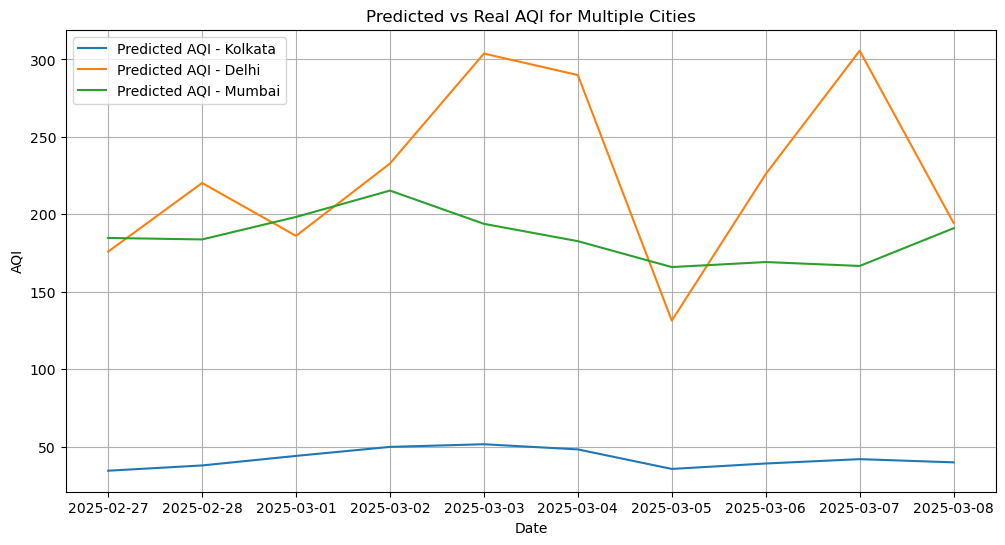

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['Datetime'].dt.date)

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

def train_bilstm_model(df_city, city_name):
    if df_city.empty:
        raise ValueError(f"No data available for {city_name}.")
    
    df_city = df_city.dropna(subset=['Index Value'])
    if len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}. Minimum 31 days required.")
    
    scaler = MinMaxScaler()
    df_city['Scaled_AQI'] = scaler.fit_transform(df_city[['Index Value']])
    
    look_back = 30  # Days of past data used for prediction
    max_past_years = 5  # Limit the number of past years to avoid variable-length inputs
    X, y = [], []
    
    for i in range(look_back, len(df_city)):
        past_30_days = df_city['Scaled_AQI'].iloc[i-look_back:i].values
        same_day_past_years = df_city[df_city['date'].dt.strftime('%m-%d') == df_city['date'].iloc[i].strftime('%m-%d')]['Scaled_AQI'].values[-max_past_years:]
        
        if len(same_day_past_years) < max_past_years:
            same_day_past_years = np.pad(same_day_past_years, (0, max_past_years - len(same_day_past_years)), 'constant', constant_values=0)
        
        combined_features = np.concatenate((past_30_days, same_day_past_years))
        X.append(combined_features)
        y.append(df_city['Scaled_AQI'].iloc[i])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(X.shape[1], 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)
    
    # Save model and scaler
    model_path = f"/mnt/data/bilstm_model_{city_name}.h5"
    model.save(model_path)
    scalers[city_name] = scaler
    models[city_name] = model
    
    return model, scaler, look_back

# Train models for all cities
for city in cities:
    df_city = df[df['City'] == city].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    try:
        model, scaler, look_back = train_bilstm_model(df_city, city)
    except ValueError as e:
        print(f"Skipping {city}: {e}")

def predict_future_aqi(future_date, city_name):
    if city_name not in models:
        model_path = f"/mnt/data/bilstm_model_{city_name}.h5"
        if os.path.exists(model_path):
            models[city_name] = load_model(model_path, compile=False)
            models[city_name].compile(optimizer='adam', loss='mean_squared_error')
        else:
            raise ValueError(f"Model for {city_name} not found.")
    
    df_city = df[df['City'] == city_name].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    scaler = scalers.get(city_name)
    if scaler is None:
        raise ValueError(f"Scaler for {city_name} not found.")
    
    if df_city.empty or len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}.")
    
    df_city['Scaled_AQI'] = scaler.transform(df_city[['Index Value']])
    past_30_days = df_city['Scaled_AQI'].iloc[-30:].values
    same_day_past_years = df_city[df_city['date'].dt.strftime('%m-%d') == future_date.strftime('%m-%d')]['Scaled_AQI'].values[-5:]
    
    if len(same_day_past_years) < 5:
        same_day_past_years = np.pad(same_day_past_years, (0, 5 - len(same_day_past_years)), 'constant', constant_values=0)
    
    combined_features = np.concatenate((past_30_days, same_day_past_years))
    last_days = combined_features.reshape((1, combined_features.shape[0], 1))
    
    pred_scaled = models[city_name].predict(last_days)
    pred_aqi = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
    
    return pred_aqi

# Example usage
if __name__ == "__main__":
    future_dates = pd.date_range(start="2025-02-27", periods=10, freq='D')
    visualize_predictions_with_real_values(cities[:3], future_dates)


Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0177
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0059
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0055
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0078
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0060
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0074
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0067
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0055
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0058
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0061
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0050
Epoch 16/20
70

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0259
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0142
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0106
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0104
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0100
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0113
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0102
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0099
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0120
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0106
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0108
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0108
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0106
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0099
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0098
Epoch 16/20
48/

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0145
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0056
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0053
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0047
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0048
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0038
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0043
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0051
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0046
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0046
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040
Epoch 16/20
65/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

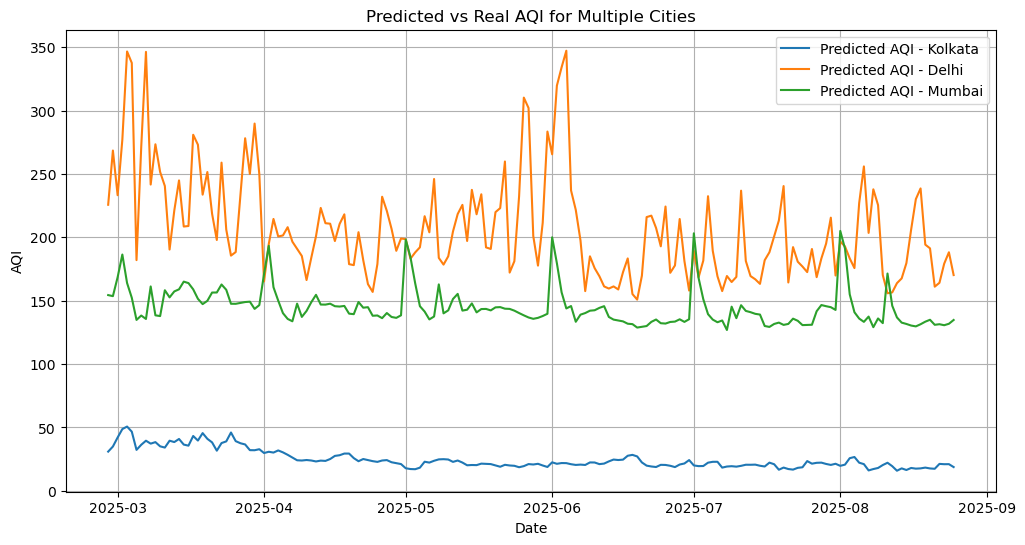

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['Datetime'].dt.date)

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

def visualize_predictions_with_real_values(cities, future_dates):
    plt.figure(figsize=(12, 6))
    
    for city in cities:
        predictions = []
        real_values = []
        dates = pd.to_datetime(future_dates)
        
        df_city = df[df['City'] == city].copy()
        df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
        df_city['Index Value'] = df_city['PM2.5']
        df_city['date'] = pd.to_datetime(df_city['date'])
        
        for date in dates:
            predicted_aqi = predict_future_aqi(date, city)
            predictions.append(predicted_aqi)
            real_value = df_city[df_city['date'] == date]['Index Value'].values
            real_values.append(real_value[0] if len(real_value) > 0 else None)
        
        sns.lineplot(x=dates, y=predictions, label=f'Predicted AQI - {city}')
        sns.scatterplot(x=dates, y=real_values, label=f'Real AQI - {city}', marker='o')
    
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title('Predicted vs Real AQI for Multiple Cities')
    plt.legend()
    plt.grid()
    plt.show()

# Train models for all cities
for city in cities:
    df_city = df[df['City'] == city].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    try:
        model, scaler, look_back = train_bilstm_model(df_city, city)
    except ValueError as e:
        print(f"Skipping {city}: {e}")

# Example usage
if __name__ == "__main__":
    future_dates = pd.date_range(start="2025-02-27", periods=180, freq='D')  # 6 months of predictions
    visualize_predictions_with_real_values(cities[:3], future_dates)


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0176
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0076
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0075
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0060
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0076
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0072
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0063
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0055
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0050
Epo

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0264
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0143
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0130
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0113
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0129
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0108
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0100
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0105
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0117
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0103
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0095
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0098
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0103
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0097
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0111
Epoch 16/20
48/

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0149
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0060
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0043
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0049
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0051
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0043
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0048
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036
Epoch 16/20
65

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

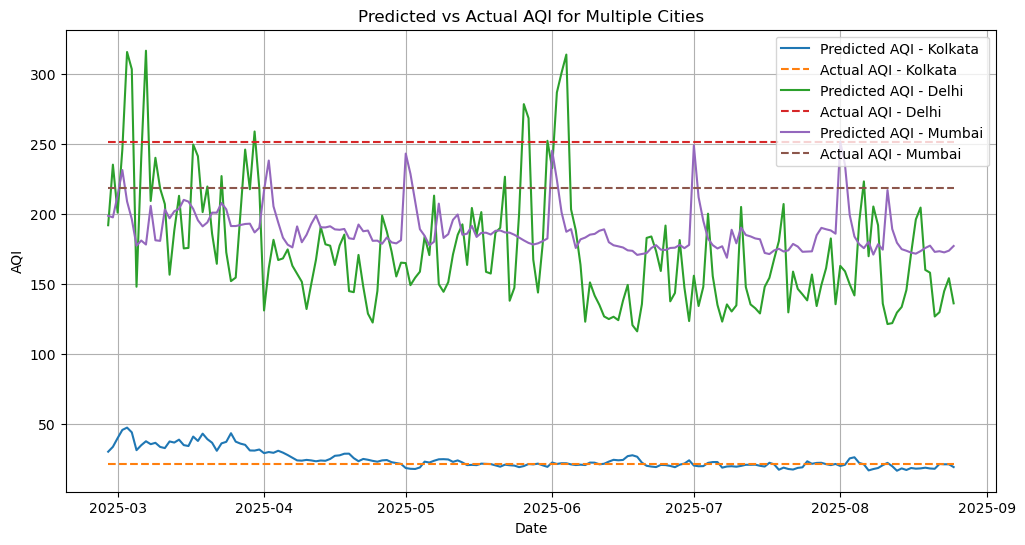

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['Datetime'].dt.date)

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

def visualize_predictions_with_real_values(cities, future_dates):
    plt.figure(figsize=(12, 6))
    
    for city in cities:
        predictions = []
        real_values = []
        dates = pd.to_datetime(future_dates)
        
        df_city = df[df['City'] == city].copy()
        df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
        df_city['Index Value'] = df_city['PM2.5']
        df_city['date'] = pd.to_datetime(df_city['date'])
        
        for date in dates:
            predicted_aqi = predict_future_aqi(date, city)
            predictions.append(predicted_aqi)
            
            # Get actual AQI values from past records
            past_real_values = df_city[df_city['date'] < date]['Index Value'].values[-1] if not df_city[df_city['date'] < date].empty else None
            real_values.append(past_real_values)
        
        sns.lineplot(x=dates, y=predictions, label=f'Predicted AQI - {city}')
        sns.lineplot(x=dates, y=real_values, label=f'Actual AQI - {city}', linestyle='dashed')
    
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title('Predicted vs Actual AQI for Multiple Cities')
    plt.legend()
    plt.grid()
    plt.show()

# Train models for all cities
for city in cities:
    df_city = df[df['City'] == city].copy()
    df_city = df_city.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city['Index Value'] = df_city['PM2.5']
    df_city['date'] = pd.to_datetime(df_city['date'])
    
    try:
        model, scaler, look_back = train_bilstm_model(df_city, city)
    except ValueError as e:
        print(f"Skipping {city}: {e}")

# Example usage
if __name__ == "__main__":
    future_dates = pd.date_range(start="2025-02-27", periods=180, freq='D')  # 6 months of predictions
    visualize_predictions_with_real_values(cities[:3], future_dates)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['Datetime'].dt.date)

# Split dataset: train on data until 2022, test on 2023
df_train = df[df['date'].dt.year <= 2022]
df_test = df[df['date'].dt.year == 2023]

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

def train_bilstm_model(df_city, city_name):
    if df_city.empty:
        raise ValueError(f"No data available for {city_name}.")
    
    df_city = df_city.dropna(subset=['Index Value'])
    if len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}. Minimum 31 days required.")
    
    scaler = MinMaxScaler()
    df_city['Scaled_AQI'] = scaler.fit_transform(df_city[['Index Value']])
    
    look_back = 30
    max_past_years = 5
    X, y = [], []
    
    for i in range(look_back, len(df_city)):
        past_30_days = df_city['Scaled_AQI'].iloc[i-look_back:i].values
        same_day_past_years = df_city[df_city['date'].dt.strftime('%m-%d') == df_city['date'].iloc[i].strftime('%m-%d')]['Scaled_AQI'].values[-max_past_years:]
        
        if len(same_day_past_years) < max_past_years:
            same_day_past_years = np.pad(same_day_past_years, (0, max_past_years - len(same_day_past_years)), 'constant', constant_values=0)
        
        combined_features = np.concatenate((past_30_days, same_day_past_years))
        X.append(combined_features)
        y.append(df_city['Scaled_AQI'].iloc[i])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(X.shape[1], 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)
    
    models[city_name] = model
    scalers[city_name] = scaler

def predict_test_aqi(city_name):
    if city_name not in models:
        raise ValueError(f"Model for {city_name} not found.")
    
    df_city_test = df_test[df_test['City'] == city_name].copy()
    df_city_test = df_city_test.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city_test['Index Value'] = df_city_test['PM2.5']
    df_city_test['date'] = pd.to_datetime(df_city_test['date'])
    
    scaler = scalers[city_name]
    df_city_test['Scaled_AQI'] = scaler.transform(df_city_test[['Index Value']])
    
    predictions = []
    actual_values = df_city_test['Index Value'].values
    dates = df_city_test['date'].values
    
    for i in range(len(df_city_test)):
        if i < 30:
            predictions.append(None)  # Not enough past data
            continue
        past_30_days = df_city_test['Scaled_AQI'].iloc[i-30:i].values.reshape((1, 30, 1))
        pred_scaled = models[city_name].predict(past_30_days)
        pred_aqi = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
        predictions.append(pred_aqi)
    
    return dates, actual_values, predictions

def visualize_predictions_vs_actual(cities):
    plt.figure(figsize=(12, 6))
    
    for city in cities:
        dates, actual_values, predictions = predict_test_aqi(city)
        sns.lineplot(x=dates, y=predictions, label=f'Predicted AQI - {city}')
        sns.lineplot(x=dates, y=actual_values, label=f'Actual AQI - {city}', linestyle='dashed')
    
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title('Predicted vs Actual AQI for 2023')
    plt.legend()
    plt.grid()
    plt.show()

# Train models using data until 2022
for city in cities:
    df_city_train = df_train[df_train['City'] == city].copy()
    df_city_train = df_city_train.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city_train['Index Value'] = df_city_train['PM2.5']
    df_city_train['date'] = pd.to_datetime(df_city_train['date'])
    
    try:
        train_bilstm_model(df_city_train, city)
    except ValueError as e:
        print(f"Skipping {city}: {e}")

# Example usage
if __name__ == "__main__":
    visualize_predictions_vs_actual(cities[:3])

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0163
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0072
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0061
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0064
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0059
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0057
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0053
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0056
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0054
Epoch 16/20
70

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0210
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0137
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0128
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0100
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0111
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0129
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0111
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0110
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0106
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0100
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0096
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0095
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0089
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0107
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0098
Epoch 16/20
46/

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0221
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0109
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0087
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0099
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0089
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0077
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0067
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0075
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0074
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0069
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0066
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0073
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0073
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0087
Epoch 16/20
44

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

<Figure size 1200x600 with 0 Axes>

Epoch 1/20


d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0191
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0073
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0071
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0064
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0064
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0053
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0068
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0056
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0051
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0060
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 13/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0050
Epoch 14/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0054
Epoch 15/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0057
Epoch 16/20
70/

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0272
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0141
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0138
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0107
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0112
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0118
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0090
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0111
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0112
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0085
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0092
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0110
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0097
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084
Epoch 16/20
46/

d:\Anacondaa\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0289
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0119
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0085
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0096
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0081
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0077
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0078
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0073
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0068
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0073
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0081
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0066
Epoch 13/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0068
Epoch 14/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0065
Epoch 15/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0075
Epoch 16/20
44

C:\Users\ASUS\AppData\Local\Temp\ipykernel_48452\407232258.py:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_city_test['Index Value'].fillna(df_city_test['Index Value'].median(), inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_48452\407232258.py:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

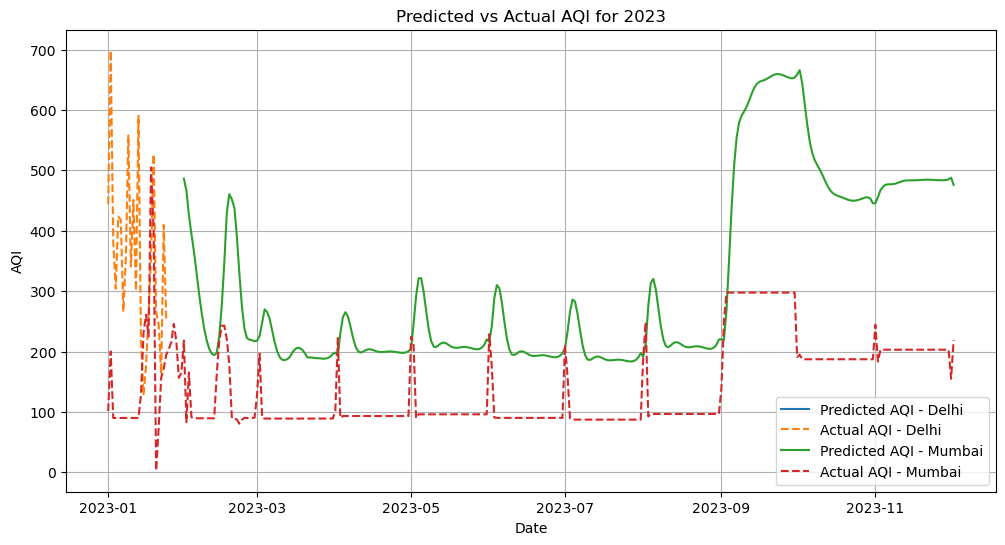

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import os

# Load dataset
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['Datetime'].dt.date)

# Split dataset: train on data until 2022, test on 2023
df_train = df[df['date'].dt.year <= 2022]
df_test = df[df['date'].dt.year == 2023]

# Get unique cities
cities = df['City'].unique()

# Dictionary to store models and scalers
models = {}
scalers = {}

def train_bilstm_model(df_city, city_name):
    if df_city.empty:
        raise ValueError(f"No data available for {city_name}.")
    
    df_city = df_city.dropna(subset=['Index Value'])
    if len(df_city) <= 30:
        raise ValueError(f"Not enough historical data for {city_name}. Minimum 31 days required.")
    
    scaler = MinMaxScaler()
    df_city['Scaled_AQI'] = scaler.fit_transform(df_city[['Index Value']])
    
    look_back = 30
    max_past_years = 5
    X, y = [], []
    
    for i in range(look_back, len(df_city)):
        past_30_days = df_city['Scaled_AQI'].iloc[i-look_back:i].values
        same_day_past_years = df_city[df_city['date'].dt.strftime('%m-%d') == df_city['date'].iloc[i].strftime('%m-%d')]['Scaled_AQI'].values[-max_past_years:]
        
        if len(same_day_past_years) < max_past_years:
            same_day_past_years = np.pad(same_day_past_years, (0, max_past_years - len(same_day_past_years)), 'constant', constant_values=0)
        
        combined_features = np.concatenate((past_30_days, same_day_past_years))
        X.append(combined_features)
        y.append(df_city['Scaled_AQI'].iloc[i])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(X.shape[1], 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=20, batch_size=16, verbose=1)
    
    models[city_name] = model
    scalers[city_name] = scaler

def predict_test_aqi(city_name):
    if city_name not in models:
        raise ValueError(f"Model for {city_name} not found.")
    
    df_city_test = df_test[df_test['City'] == city_name].copy()
    df_city_test = df_city_test.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city_test['Index Value'] = df_city_test['PM2.5']
    df_city_test['date'] = pd.to_datetime(df_city_test['date'])
    
    # Check for empty test data
    if df_city_test.empty:
        print(f"Skipping {city_name} - No test data available.")
        return [], [], []
    
    # Fill missing values if needed
    df_city_test['Index Value'].fillna(df_city_test['Index Value'].median(), inplace=True)
    
    scaler = scalers[city_name]
    df_city_test['Scaled_AQI'] = scaler.transform(df_city_test[['Index Value']])
    
    predictions = []
    actual_values = df_city_test['Index Value'].values
    dates = df_city_test['date'].values
    
    for i in range(len(df_city_test)):
        if i < 30:
            predictions.append(None)  # Not enough past data
            continue
        past_30_days = df_city_test['Scaled_AQI'].iloc[i-30:i].values.reshape((1, 30, 1))
        pred_scaled = models[city_name].predict(past_30_days)
        pred_aqi = scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
        predictions.append(pred_aqi)
    
    return dates, actual_values, predictions

def visualize_predictions_vs_actual(cities):
    plt.figure(figsize=(12, 6))
    
    for city in cities:
        dates, actual_values, predictions = predict_test_aqi(city)
        if len(dates) == 0:
            continue  # Skip cities with no test data
        sns.lineplot(x=dates, y=predictions, label=f'Predicted AQI - {city}')
        sns.lineplot(x=dates, y=actual_values, label=f'Actual AQI - {city}', linestyle='dashed')
    
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title('Predicted vs Actual AQI for 2023')
    plt.legend()
    plt.grid()
    plt.show()

# Train models using data until 2022
for city in cities:
    df_city_train = df_train[df_train['City'] == city].copy()
    df_city_train = df_city_train.groupby('date')[['PM2.5', 'PM10']].mean().reset_index()
    df_city_train['Index Value'] = df_city_train['PM2.5']
    df_city_train['date'] = pd.to_datetime(df_city_train['date'])
    
    try:
        train_bilstm_model(df_city_train, city)
    except ValueError as e:
        print(f"Skipping {city}: {e}")

# Example usage
if __name__ == "__main__":
    visualize_predictions_vs_actual(cities[:3])
